# TP - Markov Chain Monte Carlo
_(source : https://github.com/fonnesbeck/scientific-python-workshop/blob/master/notebooks/MCMC.ipynb)_

# Comment marchent les MCMC ?
## Chaînes de Markov réversibles

Les méthodes Markov Chain Monte Carlo (MCMC) simulent une chaîne pour laquelle une fonction d'intérêt $f$ (exemple : la distribution jointe des paramètres du modèle) est la distribution invariante limite unique de la Chaîne de Markov sous-jacente.

Une distribution invariante rapport à une Markov Chaîne, avec un noyau de transition $\mathbb{P}(P(y|x)\pi(x)dx$ implique :

$$\sum_x P(y | x) \pi(x) dx = \pi(y)$$

L'invariance (ou la stationnarité) est garantie pour une **chaîne de Markov** reversible.

Considérons la séquence inverse d'une chaîne de Markov ${\theta^{(n)}, \theta^{(n-1)}, ..., \theta^{(0)}}$. La séquence est toujours Markovienne car :

$$P(\theta^{(k)} = y | \theta^{(k+1)} = x, \theta^{(k+2)} = x_1, ...) = P(\theta^{(k)} = y | \theta^{(k+1)} = x)$$

Les distribtions de transitions de probabilités **directe** et dans le sens **inverse** peuvent être reliées par le Théorème de Bayes :

$$\frac{P(\theta^{(k+1)} = x | \theta^{(k)} = y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}$$

Ici la distribtion $\pi$ exploite le fait que la chaîne devient stationnaire au bout d'un certain nombre d'itérations, en exploitant les propriétés de convergence de la chaîne :
- $n \rightarrow \infty$
- $\pi^{(i)} = \pi$ pour $i \lt k$

Dans ce cas, le théorème de Bayes est vérifié en pratique :
$$\pi(x) \mathbb{P}(y|x) = \pi(y) \mathbb{P}(x | y)$$

**Remarque** : La réversibilité est la propriété qui fait que Markov Chain Monte Carlo fonctionne en pratique ! C'est elle qui permet de converger vers la "bonne" distribution stationnaire $\pi$, celle qui fonctionne en pratique et qui représente la loi marginale des données **$P(data) = \pi$** (dans le problème qu'on souhiate résoudre).

## 1. The Metropolis-Hastings Algorithm

L'algorithme de Metropolis-Hastings génère les probabilités de transitions d'une distribution alternative puis accepte les candidats de manière probabiliste.

Considérons un algorithme de Metropolis-Hastings pour un paramètre $\theta$. On utilise une distribution d'échantillonage appelée **proposal distribution** pour produire les candidats $q_t(\theta, \theta')$.
La valeur générée $\theta'$ est une valeur possible pour $\theta$ au temps $t+1$. On doit également calculer la probabilité de revenir à la valeur initiale $\theta$ depuis le candidat $\theta'$, soit $q_t(\theta|\theta')$.
Ces ingrédients définissent un **acceptance ratio**:

$$a(\theta', \theta) = \frac{q_t(\theta'|\theta)\pi(\theta')}{q_t(\theta|\theta')\pi(\theta)}$$

La valeur de $\theta_{t+1}$ est déterminée par :

$$
\theta_{t+1} = \left\{
  \begin{array}{rcl}
  \theta'\; avec une probabilité de\; min(a(\theta', \theta_t), 1)\\
  \theta_t\; avec une probabilité de\;  1 - min(a(\theta', \theta_t), 1)\\
\end{array}
\right.
$$

Il y a mouvement seulement si la transition proposée est acceptée selon l'_acceptance ratio_.

### Algorithme de Metropolis-Hastings, fonctionnement

A l'origine, l'algorithme de Metropolis-Hastings

1. Tirer $\theta'$ de la distribution $q(\theta'|\theta)$,
2. Générer une variable $u$ de loi uniforme $U \sim \mathcal{U}([0,1])$
3. $\theta_{t+1} = \theta'$ si $a(\theta', \theta) \gt u$; $\theta_{t+1} = \theta_t$ sinon.

## 2. Random-walk Metropolis Hastings

Une implémentation pratique de l'algorithme de Métropolis-Hastings suit une marche aléatoire.


_Rappel_ : Une marche aléatoire est une chaîne de Markov qui évolue selon :

$$\theta_{t+1} = \theta_t + \epsilon_t\; où\; \epsilon_t \sim f(\phi)$$

Appliquée à l'échantillonnage de MCMC, la marche aléatoire est utilisée comme une _proposal distribution_ où les propositions sont générées comme :

$$q(\theta'|\theta_t) = f(\theta' - \theta_t) = \theta_t + \epsilon_t$$

Généralement, la densité de probabilité qui génère $\epsilon_t$ est symétrique autour de 0, ce qui engendre une chaîne symétrique. La symétrie implique que $q(\theta'|\theta_t) = q(\theta_t|\theta')$, ce qui réduit l'_acceptance ratio_ à :

$$a(\theta', \theta) = \frac{\pi(\theta')}{\pi(\theta)}$$

En pratique, la disribution pour la marche aléatoire $\epsilon_t$ est souvent une loi normale ou une loi de Student $t$.



## 3. Example : Linear model estimation

On se donne un jeu de données qui représente les prix de l'immobilier associés à l'âge de chaque maison. On souhaite estimer une relation linéaire entre les 2
variables, en utilisant l'algorithme de Metropolis-Hastings.

$$\mu_i = a + b\; a_i$$
$$p_i \sim \mathcal{N}(\mu_i, \tau)$$

où
- $p_i$ est le prix
- $\mu_i$ est le prix moyen en fonction de l'âge
- $a_i$ est l'âge de la maison

In [ ]:
import numpy as np

age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11,
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14,
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800,
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000,
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500,
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

Rappel :
$$P(\theta | data) = \frac{P(\theta)P(data | \theta)}{P(data)}$$

où
- $P(\theta)$ : prior, distribution à priori (paramètres choisis)
- $P(data | \theta)$ : likelihood, vraisemblance (issu des données)
- $P(\theta | data)$: posterior, distribution à posteriori (ce qu'on cherche)
- $P(data)$ : loi marginale des données (ce qu'on ne veut pas calculer car trop coûteux)

In [ ]:
from scipy.stats import distributions


dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
  # Calculate joint posterior

  # Prior on a and b
  log_prior = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)

  # Priori on t
  log_prior += dgamma(t, 0.001, 0.001)

  # Calculate mu
  mu = a + b * x

  # Likelihood
  log_like = dnorm(y, mu, t).sum()

  return log_prior + log_like

In [ ]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)

    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params

    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))

    # Set initial values
    trace[0] = initial_values

    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])

    # Initialize acceptance counts
    accepted = [0]*n_params

    for i in range(n_iterations):

        if not i%1000: print('Iteration %i' % i)

        # Grab current parameter values
        current_params = trace[i]

        for j in range(n_params):

            # Get current value for parameter j
            p = trace[i].copy()

            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])

            # Insert new value
            p[j] = theta

            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)

            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob

            # Sample a uniform random variate
            u = runif()

            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]

    return trace, accepted


Let's run the MH algorithm with a very small proposal variance :

In [ ]:
n_iter = 10000
tracer, acc = metropolis(n_iter, (1, 0, 1), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


We can see that the acceptance rate is way too high

In [ ]:
np.array(acc, float)/n_iter

array([0.9785, 0.9674, 0.9642])

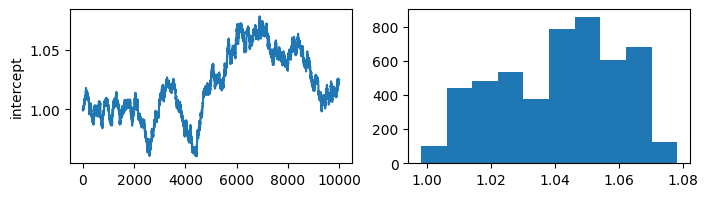

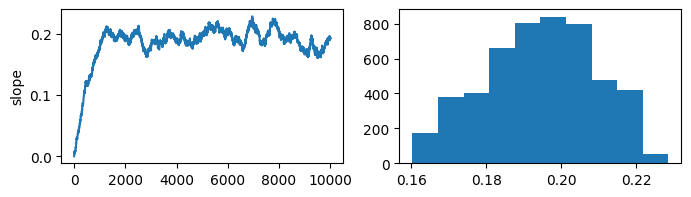

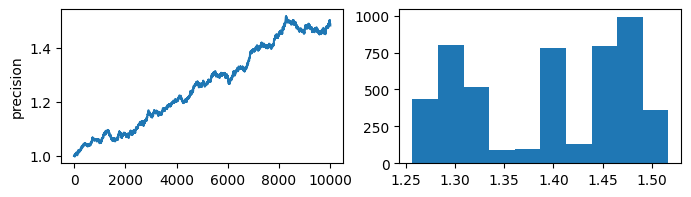

In [ ]:
import matplotlib.pyplot as plt
for param, samples in zip(['intercept', 'slope', 'precision'], tracer.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Now, with a very large proposal variance :

In [ ]:
trace_hivar, acc = metropolis(n_iter, (1,0,1), 10)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [ ]:
np.array(acc, float)/n_iter

array([0.022 , 0.0021, 0.0168])

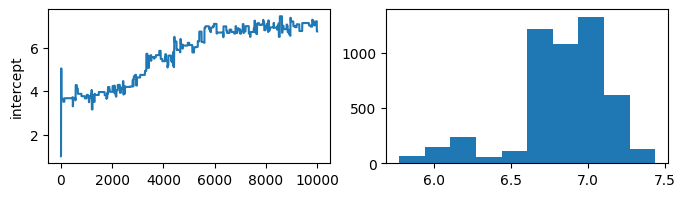

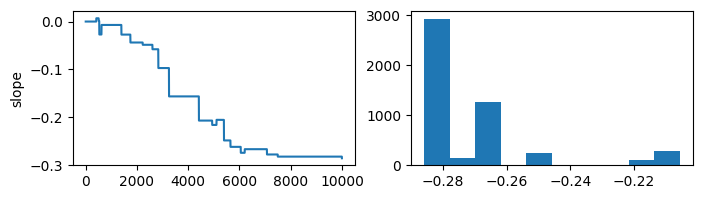

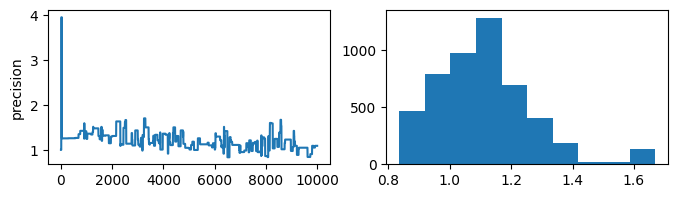

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. The following implementation of Metropolis-Hastings reduces proposal variances by 10% when the acceptance rate is low, and increases it by 10% when the acceptance rate is high.

In [ ]:
def metropolis_tuned(n_iterations, initial_values, prop_var=1,
                     tune_for=None, tune_interval=100):

    n_params = len(initial_values)

    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params

    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))

    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params

    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])

    if tune_for is None:
        tune_for = n_iterations/2

    for i in range(n_iterations):

        if not i%1000: print('Iteration %i' % i)

        # Grab current parameter values
        current_params = trace[i]

        for j in range(n_params):

            # Get current value for parameter j
            p = trace[i].copy()

            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])

            # Insert new value
            p[j] = theta

            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)

            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob

            # Sample a uniform random variate
            u = runif()

            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]

            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):

                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1
                accepted[j] = 0

    return trace[tune_for:], accepted

In [ ]:
trace_tuned, acc = metropolis_tuned(n_iter, (1,0,1), tune_for=9000)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [ ]:
np.array(acc, float)/1000

array([0.3  , 0.298, 0.268])

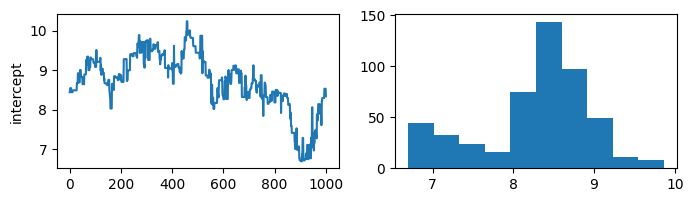

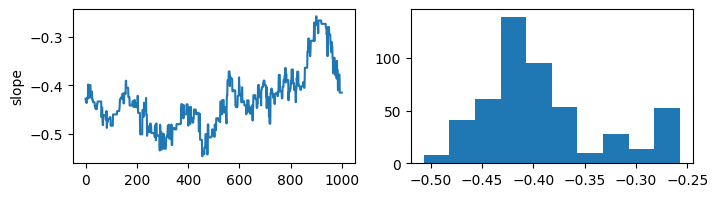

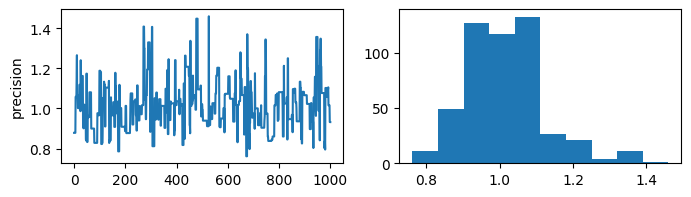

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

50 random regression lines drawn from the posterior:




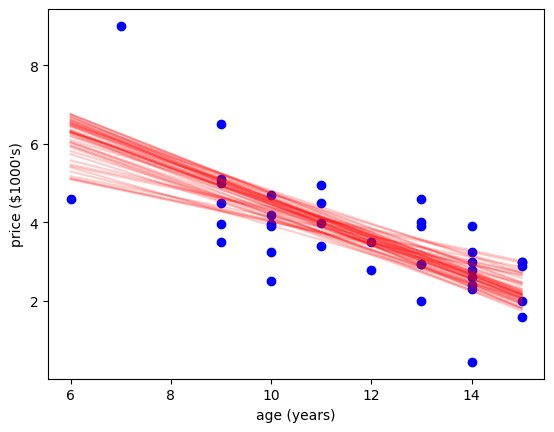

In [ ]:
import matplotlib.pyplot as plt

plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

## Exercice :  Bioassay analysis



Gelman et al. (2003) proposent un test de toxicité aigu, appliqué aux animaux pour estimer la toxicité de composants variés.

Le jeu de données _log_dose_ ci-dessous présente 4 niveaux de dosage, en échelle logarithmique, chacun administré à 5 rats pendant l'expérience. La variable de réponse est "_death_", le nombre de réponses positives au dosage.

Le nombre de morts peut être modélisé comme une loi binomiale, avec une probabilité de mortalité linéaire en fonction de la dose.

$$y_i \sim Bin(n_i, p_i)$$
$$logit(p_i) = a + b\, x_i$$

Ici on cherche à estimer la statistique **LD50**, qui représente une probabilité de mortalité de 50 % étant donnée le dosage.

Utiliser Metropolis-Hastings pour ajuster le modèle et étudier le jeu de données et estimer **LD50**.

In [ ]:
# Log dose in each group
log_dose = [-0.86, -0.3, -0.05, 0.73]

# Sample size in each group
n = 5

# Sorties
deaths = [0, 1, 3, 5]

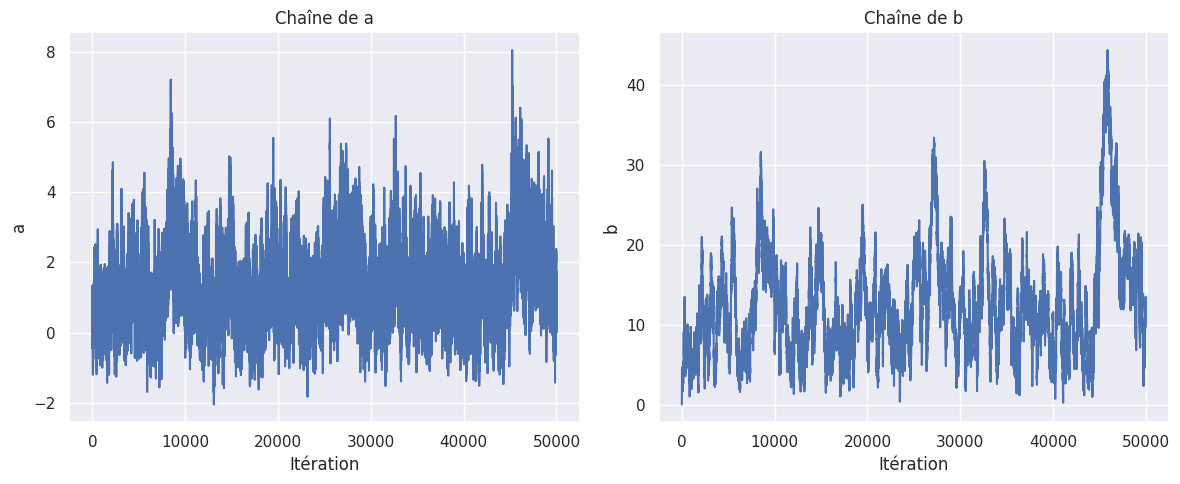

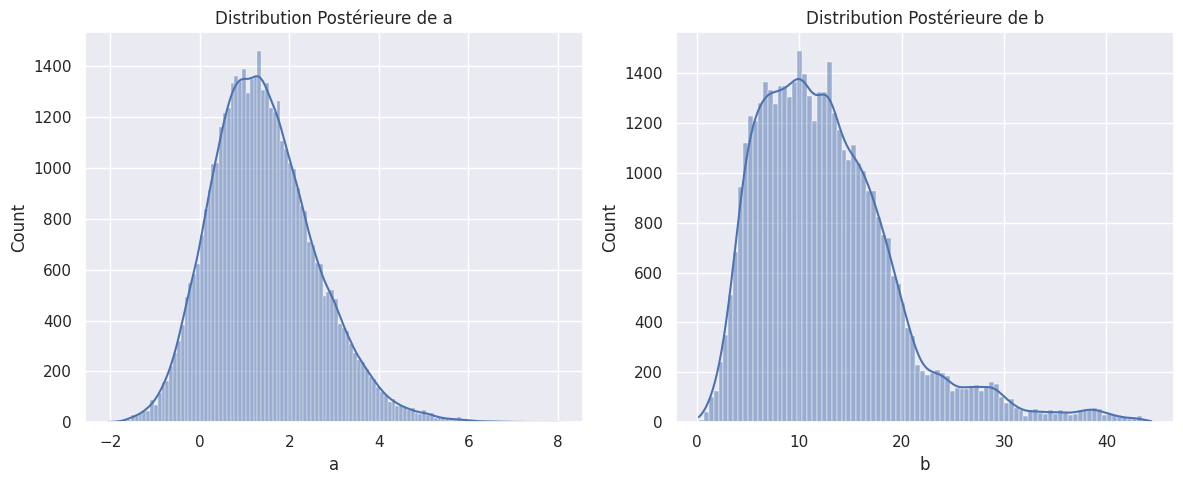

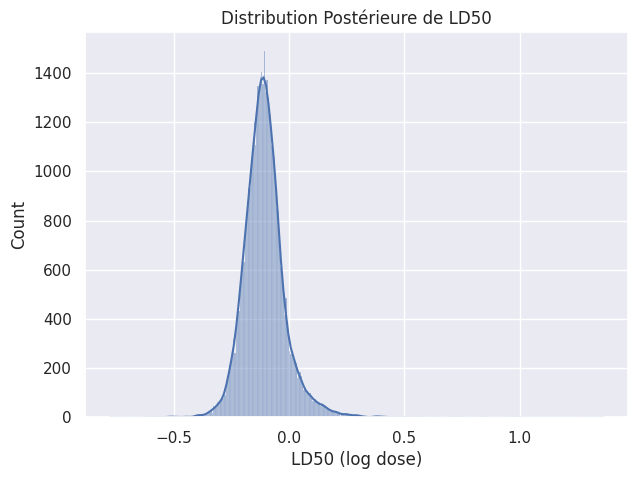

Estimation de LD50:
Moyenne : -0.1062
Intervalle de crédibilité à 95% : [-0.2636, 0.1022]


<Figure size 700x500 with 0 Axes>

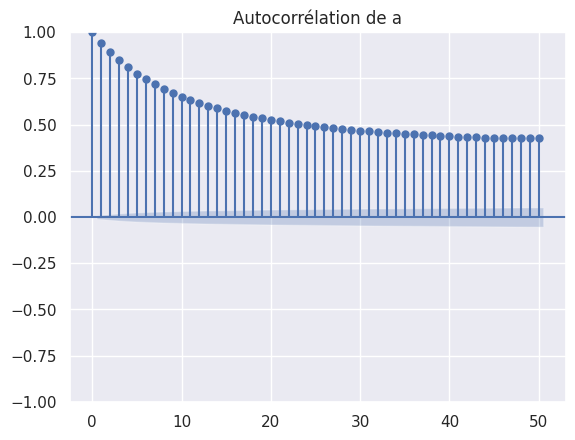

<Figure size 700x500 with 0 Axes>

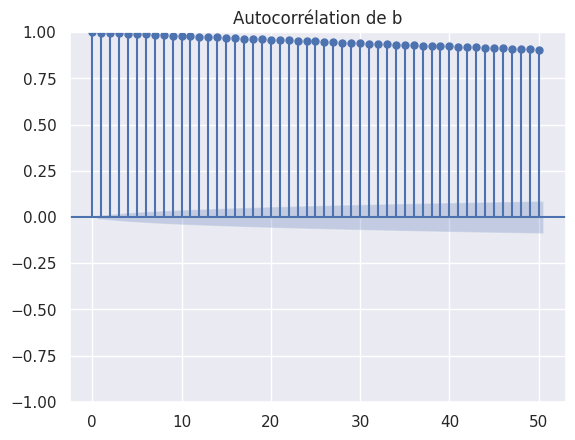

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
import seaborn as sns
sns.set()

# 1. Chargement des données
log_dose = np.array([-0.86, -0.3, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
deaths = np.array([0, 1, 3, 5])

# 2. Définition des fonctions
def log_likelihood(a, b, x, n, y):
    logit_p = a + b * x
    p = 1 / (1 + np.exp(-logit_p))
    p = np.clip(p, 1e-10, 1 - 1e-10)
    ll = np.sum(y * np.log(p) + (n - y) * np.log(1 - p))
    return ll

def log_prior(a, b):
    lp_a = norm.logpdf(a, loc=0, scale=100)
    lp_b = norm.logpdf(b, loc=0, scale=100)
    return lp_a + lp_b

def log_posterior(a, b, x, n, y):
    return log_likelihood(a, b, x, n, y) + log_prior(a, b)

def metropolis_hastings(x, n, y, iterations, initial_values, proposal_sd):
    a_chain = np.zeros(iterations)
    b_chain = np.zeros(iterations)
    a_current = initial_values[0]
    b_current = initial_values[1]
    log_post_current = log_posterior(a_current, b_current, x, n, y)
    for i in range(iterations):
        a_proposal = np.random.normal(a_current, proposal_sd[0])
        b_proposal = np.random.normal(b_current, proposal_sd[1])
        log_post_proposal = log_posterior(a_proposal, b_proposal, x, n, y)
        log_acceptance_ratio = log_post_proposal - log_post_current
        acceptance_ratio = np.exp(log_acceptance_ratio)
        if np.random.uniform(0, 1) < acceptance_ratio:
            a_current = a_proposal
            b_current = b_proposal
            log_post_current = log_post_proposal
        a_chain[i] = a_current
        b_chain[i] = b_current
    return a_chain, b_chain

# 3. Exécution de l'algorithme
iterations = 50000
initial_values = [0, 0]
proposal_sd = [0.5, 0.5]
a_chain, b_chain = metropolis_hastings(log_dose, n, deaths, iterations, initial_values, proposal_sd)

# 4. Analyse des résultats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(a_chain)
plt.title('Chaîne de a')
plt.xlabel('Itération')
plt.ylabel('a')
plt.subplot(1, 2, 2)
plt.plot(b_chain)
plt.title('Chaîne de b')
plt.xlabel('Itération')
plt.ylabel('b')
plt.tight_layout()
plt.show()

burn_in = int(iterations * 0.1)
a_posterior = a_chain[burn_in:]
b_posterior = b_chain[burn_in:]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(a_posterior, kde=True)
plt.title('Distribution Postérieure de a')
plt.xlabel('a')
plt.subplot(1, 2, 2)
sns.histplot(b_posterior, kde=True)
plt.title('Distribution Postérieure de b')
plt.xlabel('b')
plt.tight_layout()
plt.show()

# 5. Estimation de LD50
ld50_posterior = -a_posterior / b_posterior

plt.figure(figsize=(7, 5))
sns.histplot(ld50_posterior, kde=True)
plt.title('Distribution Postérieure de LD50')
plt.xlabel('LD50 (log dose)')
plt.show()

ld50_mean = np.mean(ld50_posterior)
ld50_ci = np.percentile(ld50_posterior, [2.5, 97.5])

print(f"Estimation de LD50:")
print(f"Moyenne : {ld50_mean:.4f}")
print(f"Intervalle de crédibilité à 95% : [{ld50_ci[0]:.4f}, {ld50_ci[1]:.4f}]")

# 6. Vérification de la convergence
def plot_autocorrelation(chain, title):
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(7, 5))
    plot_acf(chain, lags=50)
    plt.title(title)
    plt.show()

plot_autocorrelation(a_posterior, 'Autocorrélation de a')
plot_autocorrelation(b_posterior, 'Autocorrélation de b')
